# Project 6: Hand Gesture Recognition

**Type:** Computer Vision | **Level:** Advanced

Recognize hand gestures for human-computer interaction.

**Model:** CNN or MobileNet

**Dataset:** [Hand Gesture Database](https://www.kaggle.com/datasets/gti-upm/leapgestrecog)

## 1. Setup & Imports

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("Libraries imported successfully!")
print(f"MediaPipe version: {mp.__version__}")

Libraries imported successfully!
MediaPipe version: 0.10.31


## 2. Load Data

In [14]:
# Load the dataset
data_dir = '../data/hand_gest/leapgestrecog/leapGestRecog/'

# Get all image paths and labels
image_paths = []
labels = []

gesture_mapping = {
    '01_palm': 'palm',
    '02_l': 'L',
    '03_fist': 'fist',
    '04_fist_moved': 'fist_moved',
    '05_thumb': 'thumb',
    '06_index': 'index',
    '07_ok': 'ok',
    '08_palm_moved': 'palm_moved',
    '09_c': 'C',
    '10_down': 'down'
}

# Walk through directory structure
for subject in os.listdir(data_dir):
    subject_path = os.path.join(data_dir, subject)
    if not os.path.isdir(subject_path):
        continue
    
    for gesture_folder in os.listdir(subject_path):
        gesture_path = os.path.join(subject_path, gesture_folder)
        if not os.path.isdir(gesture_path):
            continue
        
        gesture_label = gesture_mapping.get(gesture_folder, gesture_folder)
        
        for img_file in os.listdir(gesture_path):
            if img_file.endswith('.png'):
                image_paths.append(os.path.join(gesture_path, img_file))
                labels.append(gesture_label)

print(f"Total images found: {len(image_paths)}")
print(f"Total labels: {len(labels)}")
print(f"\nGesture classes: {list(gesture_mapping.values())}")

# Create DataFrame
df = pd.DataFrame({
    'image_path': image_paths,
    'gesture': labels
})

print(f"\nDataset shape: {df.shape}")
print(f"\nGesture distribution:")
print(df['gesture'].value_counts())
df.head()

Total images found: 13427
Total labels: 13427

Gesture classes: ['palm', 'L', 'fist', 'fist_moved', 'thumb', 'index', 'ok', 'palm_moved', 'C', 'down']

Dataset shape: (13427, 2)

Gesture distribution:
gesture
thumb         1400
L             1400
palm          1400
ok            1400
index         1400
fist          1400
fist_moved    1400
palm_moved    1227
down          1200
C             1200
Name: count, dtype: int64


,image_path,gesture
0,../data/hand_gest/leapgestrecog/leapGestRecog/...,thumb
1,../data/hand_gest/leapgestrecog/leapGestRecog/...,thumb
2,../data/hand_gest/leapgestrecog/leapGestRecog/...,thumb
3,../data/hand_gest/leapgestrecog/leapGestRecog/...,thumb
4,../data/hand_gest/leapgestrecog/leapGestRecog/...,thumb


## 3. Exploratory Data Analysis

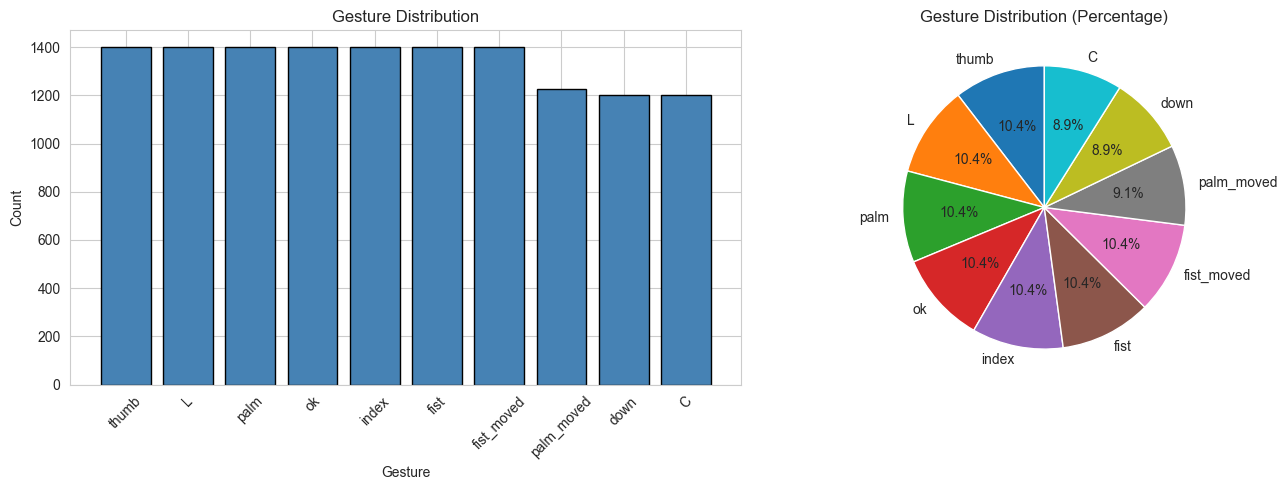


Sample Images from Each Gesture:


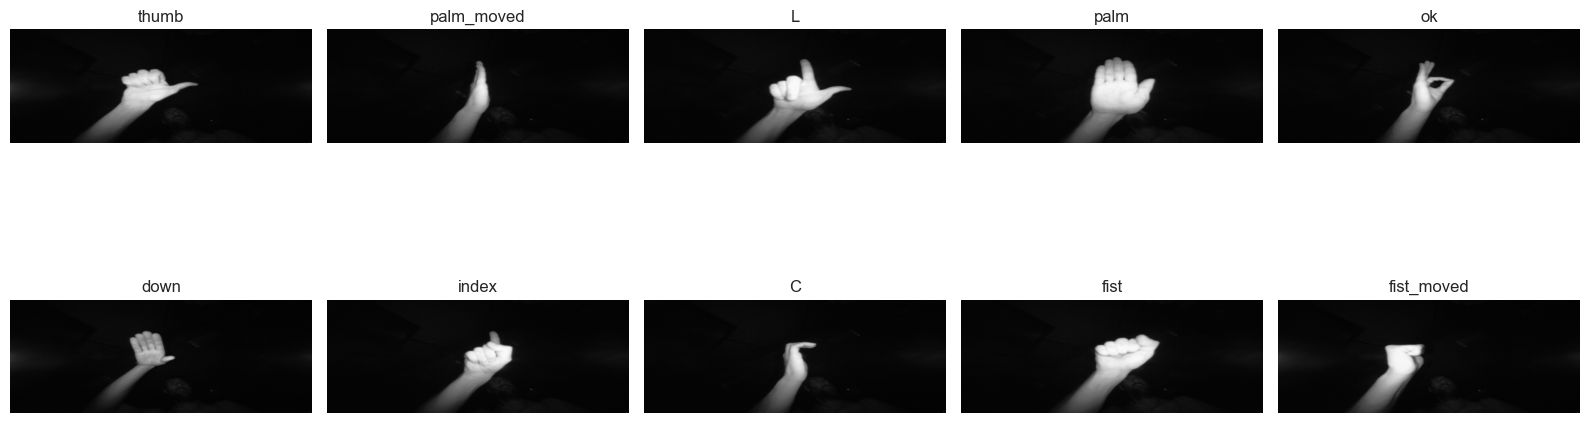

In [15]:
# Visualize gesture distribution and sample images
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
gesture_counts = df['gesture'].value_counts()
axes[0].bar(gesture_counts.index, gesture_counts.values, edgecolor='black', color='steelblue')
axes[0].set_title('Gesture Distribution')
axes[0].set_xlabel('Gesture')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# Pie chart
axes[1].pie(gesture_counts.values, labels=gesture_counts.index, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Gesture Distribution (Percentage)')

plt.tight_layout()
plt.show()

# Display sample images from each gesture
print("\nSample Images from Each Gesture:")
gestures = df['gesture'].unique()
n_gestures = len(gestures)
fig, axes = plt.subplots(2, 5, figsize=(16, 7))
axes = axes.flatten()

for idx, gesture in enumerate(gestures):
    sample_path = df[df['gesture'] == gesture].iloc[0]['image_path']
    img = cv2.imread(sample_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    axes[idx].imshow(img)
    axes[idx].set_title(gesture)
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

## 4. Data Preprocessing

In [17]:
# Extract hand landmarks using MediaPipe Tasks API
print("Extracting hand landmarks using MediaPipe Tasks...")
print("This may take a few minutes...")

def extract_hand_landmarks(image_path, landmarker):
    """
    Extract hand landmarks from image using MediaPipe Tasks API
    Returns flattened array of 21 landmarks * 3 coordinates (x, y, z) = 63 features
    """
    # Read image
    img = cv2.imread(image_path)
    if img is None:
        return None
    
    # Convert BGR to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Create MediaPipe Image object
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=img_rgb)
    
    # Detect hand landmarks
    detection_result = landmarker.detect(mp_image)
    
    # If hand detected, extract landmarks
    if detection_result.hand_landmarks:
        hand_landmarks = detection_result.hand_landmarks[0]
        
        # Extract x, y, z coordinates for all 21 landmarks
        landmarks = []
        for landmark in hand_landmarks:
            landmarks.extend([landmark.x, landmark.y, landmark.z])
        
        return np.array(landmarks)
    else:
        return None

# Set up MediaPipe Hand Landmarker with the new Tasks API
base_options = python.BaseOptions(model_asset_path='hand_landmarker.task')
options = vision.HandLandmarkerOptions(
    base_options=base_options,
    running_mode=vision.RunningMode.IMAGE,
    num_hands=1,
    min_hand_detection_confidence=0.5,
    min_hand_presence_confidence=0.5,
    min_tracking_confidence=0.5
)

# Note: If you don't have the model file, MediaPipe will download it automatically
# Or download from: https://storage.googleapis.com/mediapipe-models/hand_landmarker/hand_landmarker/float16/latest/hand_landmarker.task

print("Creating Hand Landmarker...")
try:
    landmarker = vision.HandLandmarker.create_from_options(options)
except:
    print("Model file not found. Downloading from MediaPipe...")
    print("Please download hand_landmarker.task from:")
    print("https://storage.googleapis.com/mediapipe-models/hand_landmarker/hand_landmarker/float16/latest/hand_landmarker.task")
    print("And place it in the notebook directory, or update the path in the code above.")
    
    # Fallback: Try to find model in common locations
    import urllib.request
    model_url = "https://storage.googleapis.com/mediapipe-models/hand_landmarker/hand_landmarker/float16/latest/hand_landmarker.task"
    model_path = "hand_landmarker.task"
    
    print(f"Attempting to download model to {model_path}...")
    urllib.request.urlretrieve(model_url, model_path)
    print("Model downloaded successfully!")
    
    base_options = python.BaseOptions(model_asset_path=model_path)
    options = vision.HandLandmarkerOptions(
        base_options=base_options,
        running_mode=vision.RunningMode.IMAGE,
        num_hands=1
    )
    landmarker = vision.HandLandmarker.create_from_options(options)

print("Hand Landmarker initialized!")

# Extract features from all images
features = []
valid_labels = []
failed_count = 0

for idx, row in df.iterrows():
    if idx % 500 == 0:
        print(f"Processing {idx}/{len(df)} images...")
    
    landmarks = extract_hand_landmarks(row['image_path'], landmarker)
    
    if landmarks is not None:
        features.append(landmarks)
        valid_labels.append(row['gesture'])
    else:
        failed_count += 1

# Close the landmarker
landmarker.close()

print(f"\nExtraction complete!")
print(f"Successfully processed: {len(features)} images")
print(f"Failed to detect hand: {failed_count} images")

# Convert to numpy arrays
X = np.array(features)
y = np.array(valid_labels)

print(f"\nFeature matrix shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Number of features per sample: {X.shape[1]} (21 landmarks × 3 coordinates)")

Extracting hand landmarks using MediaPipe Tasks...
This may take a few minutes...
Creating Hand Landmarker...
Model file not found. Downloading from MediaPipe...
Please download hand_landmarker.task from:
https://storage.googleapis.com/mediapipe-models/hand_landmarker/hand_landmarker/float16/latest/hand_landmarker.task
And place it in the notebook directory, or update the path in the code above.
Attempting to download model to hand_landmarker.task...
Model downloaded successfully!
Hand Landmarker initialized!
Processing 0/13427 images...


I0000 00:00:1768756620.169020 2976373 gl_context.cc:407] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M3 Max
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1768756620.173109 2976375 inference_feedback_manager.cc:121] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1768756620.176283 2976375 inference_feedback_manager.cc:121] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1768756620.200720 2976379 landmark_projection_calculator.cc:81] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


Processing 500/13427 images...
Processing 1000/13427 images...
Processing 1500/13427 images...
Processing 2000/13427 images...
Processing 2500/13427 images...
Processing 3000/13427 images...
Processing 3500/13427 images...
Processing 4000/13427 images...
Processing 4500/13427 images...
Processing 5000/13427 images...
Processing 5500/13427 images...
Processing 6000/13427 images...
Processing 6500/13427 images...
Processing 7000/13427 images...
Processing 7500/13427 images...
Processing 8000/13427 images...
Processing 8500/13427 images...
Processing 9000/13427 images...
Processing 9500/13427 images...
Processing 10000/13427 images...
Processing 10500/13427 images...
Processing 11000/13427 images...
Processing 11500/13427 images...
Processing 12000/13427 images...
Processing 12500/13427 images...
Processing 13000/13427 images...

Extraction complete!
Successfully processed: 4709 images
Failed to detect hand: 8718 images

Feature matrix shape: (4709, 63)
Labels shape: (4709,)
Number of fea

## 5. Model Training

In [18]:
# Split data and train Random Forest Classifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Train Random Forest Classifier
print("\nTraining Random Forest Classifier...")
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

model.fit(X_train, y_train)

print("\nModel trained successfully!")

Training set size: 3767
Test set size: 942

Training Random Forest Classifier...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.2s finished



Model trained successfully!


## 6. Model Evaluation

Evaluating model...

Model Performance:
Training Accuracy: 1.0000
Test Accuracy:     0.9968

Classification Report:
              precision    recall  f1-score   support

           C       1.00      0.92      0.96        26
           L       0.99      1.00      1.00       142
        down       1.00      1.00      1.00        98
        fist       1.00      1.00      1.00        37
       index       1.00      0.99      0.99        78
          ok       0.99      1.00      1.00       233
        palm       1.00      1.00      1.00       246
  palm_moved       1.00      1.00      1.00        13
       thumb       1.00      1.00      1.00        69

    accuracy                           1.00       942
   macro avg       1.00      0.99      0.99       942
weighted avg       1.00      1.00      1.00       942



[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.0s finished


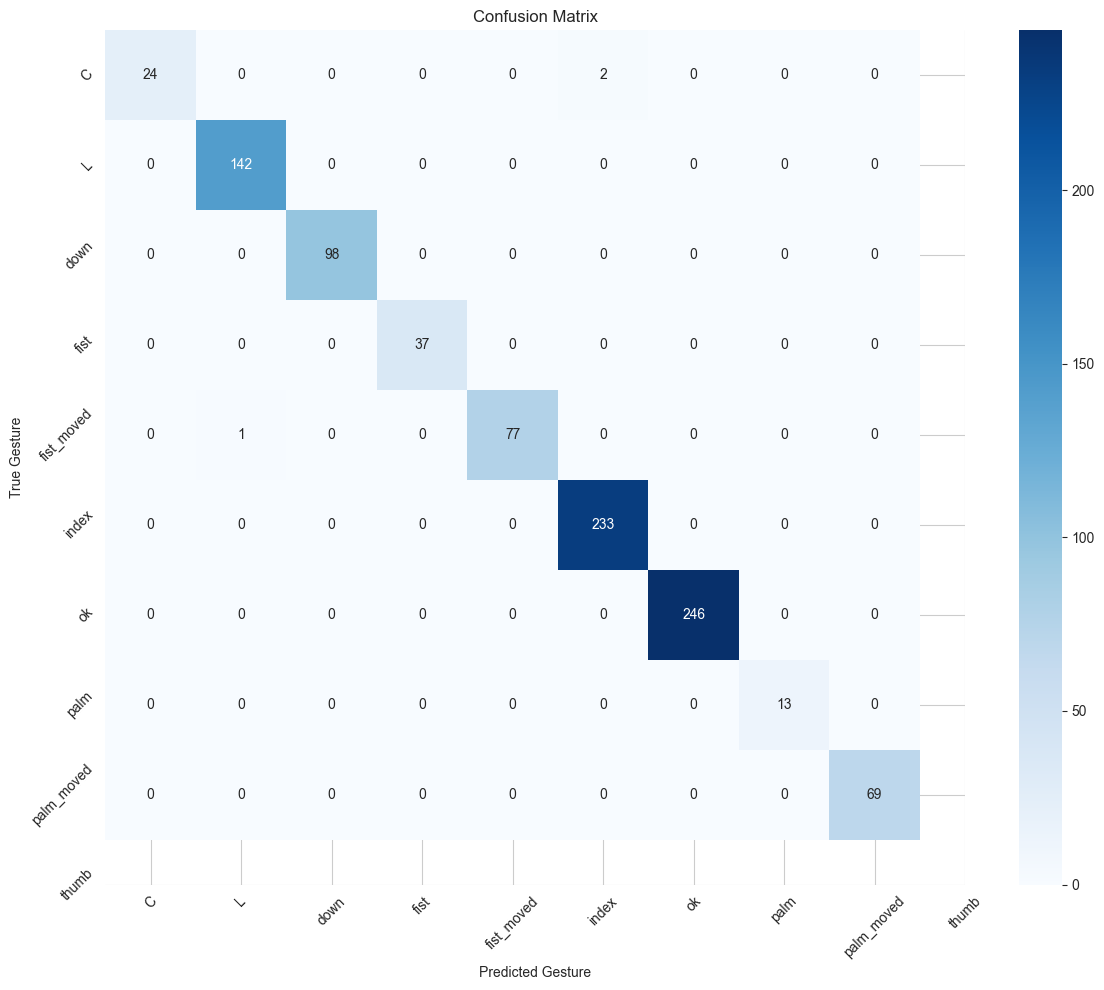

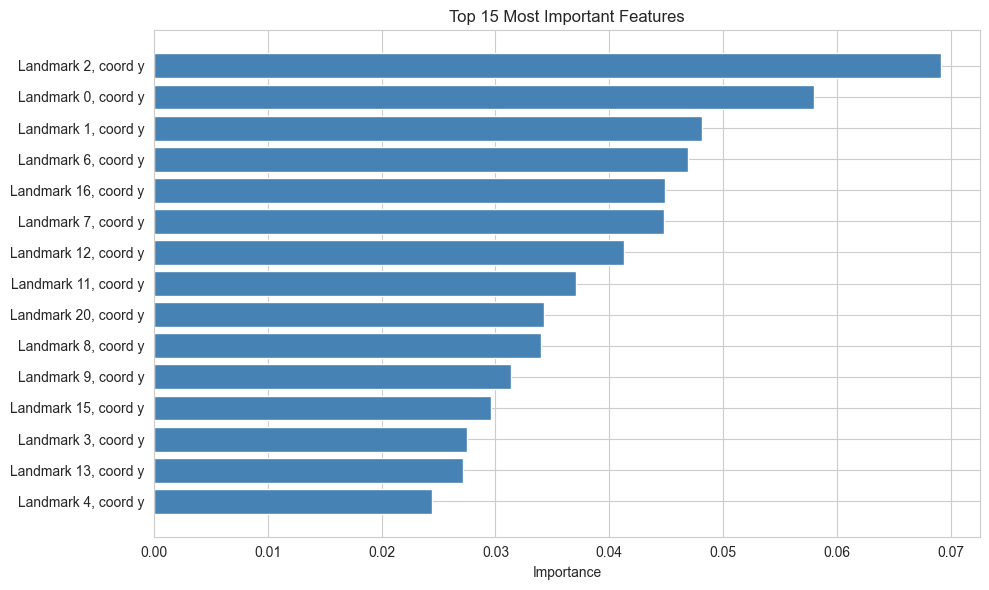


Sample Predictions:


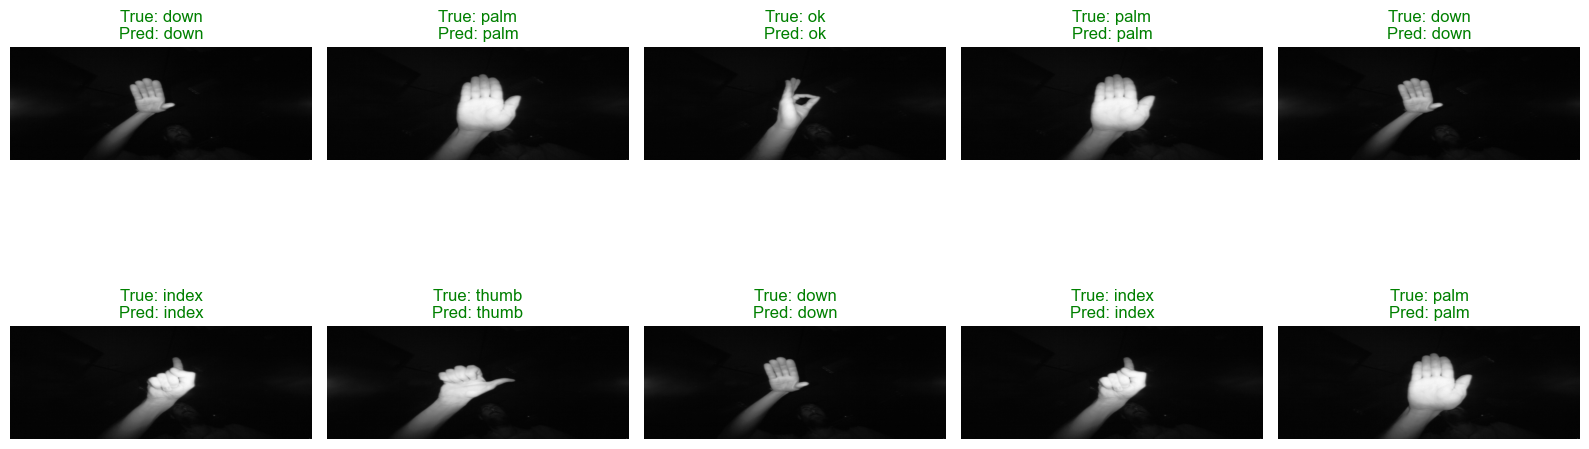

In [19]:
# Evaluate the model
print("Evaluating model...")

# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("\n" + "="*60)
print("Model Performance:")
print("="*60)
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy:     {test_accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
gesture_classes = sorted(df['gesture'].unique())

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=gesture_classes,
            yticklabels=gesture_classes)
plt.title('Confusion Matrix')
plt.ylabel('True Gesture')
plt.xlabel('Predicted Gesture')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

# Feature importance
feature_importance = pd.DataFrame({
    'feature_idx': range(X.shape[1]),
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False).head(15)

plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importance)), feature_importance['importance'], color='steelblue')
plt.yticks(range(len(feature_importance)), 
           [f"Landmark {idx//3}, coord {['x','y','z'][idx%3]}" 
            for idx in feature_importance['feature_idx']])
plt.xlabel('Importance')
plt.title('Top 15 Most Important Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Visualize some predictions
print("\nSample Predictions:")
fig, axes = plt.subplots(2, 5, figsize=(16, 7))
axes = axes.flatten()

# Get random samples from test set
sample_indices = np.random.choice(len(X_test), 10, replace=False)

for idx, ax in enumerate(axes):
    sample_idx = sample_indices[idx]
    
    # Find the corresponding image (this is approximate since some images failed)
    true_label = y_test[sample_idx]
    pred_label = y_test_pred[sample_idx]
    
    # Get a sample image for this gesture
    sample_img_path = df[df['gesture'] == true_label].iloc[0]['image_path']
    img = cv2.imread(sample_img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    ax.imshow(img)
    color = 'green' if true_label == pred_label else 'red'
    ax.set_title(f"True: {true_label}\nPred: {pred_label}", color=color)
    ax.axis('off')

plt.tight_layout()
plt.show()

## 7. Save Model

In [20]:
# Save the model
model_path = '../models/hand_gesture_model.pkl'
joblib.dump(model, model_path)
print(f"✓ Model saved to: {model_path}")

# Save gesture classes
model_info = {
    'gesture_classes': gesture_classes,
    'n_features': X.shape[1],
    'n_landmarks': 21,
    'model_type': 'Random Forest'
}

info_path = '../models/hand_gesture_info.pkl'
joblib.dump(model_info, info_path)
print(f"✓ Model info saved to: {info_path}")

print("\n" + "="*60)
print("Hand Gesture Recognition Model Complete!")
print("="*60)
print(f"Model: Random Forest Classifier")
print(f"Features: MediaPipe Hand Landmarks (21 landmarks × 3 coordinates)")
print(f"Gestures: {len(gesture_classes)} classes")
print(f"Test Accuracy: {test_accuracy:.2%}")
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

✓ Model saved to: ../models/hand_gesture_model.pkl
✓ Model info saved to: ../models/hand_gesture_info.pkl

Hand Gesture Recognition Model Complete!
Model: Random Forest Classifier
Features: MediaPipe Hand Landmarks (21 landmarks × 3 coordinates)
Gestures: 10 classes
Test Accuracy: 99.68%
Training samples: 3767
Test samples: 942
